In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import arviz as az
from IPython.display import IFrame

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [3]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});


##### <center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Análisis exploratorio de modelos Bayesianos</h1> 
<h2 align="center">Diagnóstico del muestreo</h2> 



<br>
<br>
<br>
<br>
<br>

## ArviZ: Análisis exploratorio de modelos Bayesianos

<br>
<br>
<center><img src="img/logo_arviz.png" width=400></center>
<br>

* Diagnosticar la calidad de la inferencia
* <font color = "gray"> Criticar a los modelos, incluyendo la evaluación de los supuestos del modelo y de sus predicciones </font>
* <font color = "gray">Comparación de modelos, incluyendo la selección y promediado de modelos </font>
* <font color = "gray">Preparar los resultados para una audiencia particular </font>

## Calcular la distribución a posteriori

* Hay muchas formas de calcular una posterior
     * <font color = gray> Conjugación </font>
     * <font color = gray> Método de Laplace </font>
     * <font color = gray> Aproximación integrada de Laplace (INLA) </font>
     * <font color = gray> Inferencia Variacional (VI) </font>
     * Markov Chain Monte Carlo (MCMC)
     * ...


* Solo los métodos MCMC (y en menor grado VI) son suficientemente generales


* Restringiremos nuestra discusión actual a los métodos MCMC

## Cadena Markov Monte Carlo (MCMC)

<br>

* Los métodos MCMC se pueden usar para **muestrear** de distribuciones de probabilidad que son difíciles de muestrear directamente


* Si se satisfacen algunas condiciones muy generales, tenemos una garantía teórica que los métodos MCMC convergerán asintóticamente a la distribución correcta.


* Debido a que no tenemos garantías para muestras finitas, necesitamos diagnosticar la calidad de las muestras MCMC

## El algoritmo de Metrópolis-$\color{grey}{\text{Hasting}}$

1. Inicialice el valor del parámetro $x$ en $x_i$

2. Elija un nuevo valor de parámetro $x_{i + 1}$, tomando muestras de una distribución fácil de muestrear, como una distribución gaussiana $Q(x_{i + 1} \mid x_i)$.

3. Calcule la probabilidad de aceptar el nuevo valor del parámetro:

$$p_a (x_{i + 1} \mid x_i) = min \left (1, \frac{p(x_{i + 1}) \; \color{grey}{q(x_i \mid x_{i + 1}})} {p(x_i) \; \color{grey}{q (x_{i + 1} \mid p(x_i)}} \right)$$

4. Si $p_a \gt R$ donde $R \sim \mathcal{U}(0, 1)$. Acepte el nuevo valor, de lo contrario acepte el valor anterior

5. Iterar desde 2 hasta lograr una cantidad *suficiente* de muestras

In [542]:
def post(θ, Y, α=1, β=1):
    """
    Calcula la probabilidad a posteriori para el modelo:

    Likelihood: Y[i] ~ Bern(θ)
    Prior:      θ ~ Beta(α, β)
    
    θ : flotante
        valor para el cual evaluar la función
    Y : tipo array
        Datos observados
    α : flotante > 0
        parámetro del prior
    β : flotante > 1
        parámetro del prior
    """
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prop = like * prior
    else:
        prop = -np.inf
    return prop

In [543]:
# Generamos datos
np.random.seed(820)
Y = stats.bernoulli(0.7).rvs(20)

In [564]:
n_iters = 1000
can_sd = 0.3 # Prueba con valores diferentes de can_sd y evalua el efecto del acceptance rate y trace

α = 1
β = 1

θ = 0.5 # Prueba con valores diferentes del valor inicial y evalua el efecto del acceptance rate y trace
trace = np.zeros(n_iters)
p2 = post(θ, Y, α, β)
pasos_aceptados = 0

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)  # genera una propuesta
    p1 = post(θ_can, Y, α, β)  # calcular probabilidad a posteriori del candidato
    # Criterio de Metropolis
    R = p1 / p2

    if R > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1
        pasos_aceptados += 1
        
    trace[iter] = θ
pasos_aceptados / n_iters

0.363

In [565]:
az.summary(trace, kind='stats')

,mean,sd,hpd_3%,hpd_97%
x,0.694,0.088,0.538,0.849


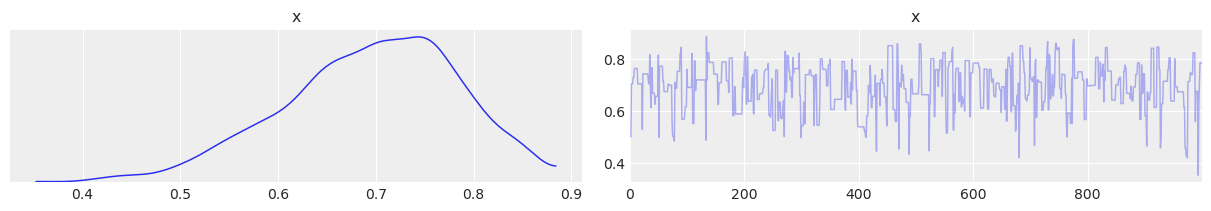

In [566]:
az.plot_trace(trace);

In [560]:
IFrame(src='mcmc-demo-master/app.html#RandomWalkMH,standard', width=1200, height=600)

## Trace plots

<br>

     az.plot_trace (trace)


* Las muestras MCMC no deben ser sensibles al punto de partida
     * Entonces, si generás más de una cadena (comenzando desde diferentes lugares), todas debeerían ser *similares* entre si
* Las muestras MCMC deben tener la autocorrelación más baja posible
     * No debería haber regiones de monoticidad

Un trace plot puedee ayudar a diagnosticar:

* Posteriors multimodales
* Mala inicialización
* Topologías difíciles (como el embudo de Neal)

## Trace patológicos

<br>

<center><img src="img/pathological_traces.png" width=600></center>

## Como arreglarlo

<br>

* Más muestras

* Burn-in

* ¡Cambiar el método de muestreo!

* Reparametrizar el modelo

* ¡Lea los mensajes de advertencia y sugerencias de PyMC3!   ;-)

## Gráfico de autocorrelación

<br>

     az.plot_autocorr (trace)

* Idealmente, una muestra debe ser independiente e idénticamente distribuida (iid)

* Por definición, las muestras MCMC están correlacionadas

* En la práctica, queremos muestras con baja autocorrelación

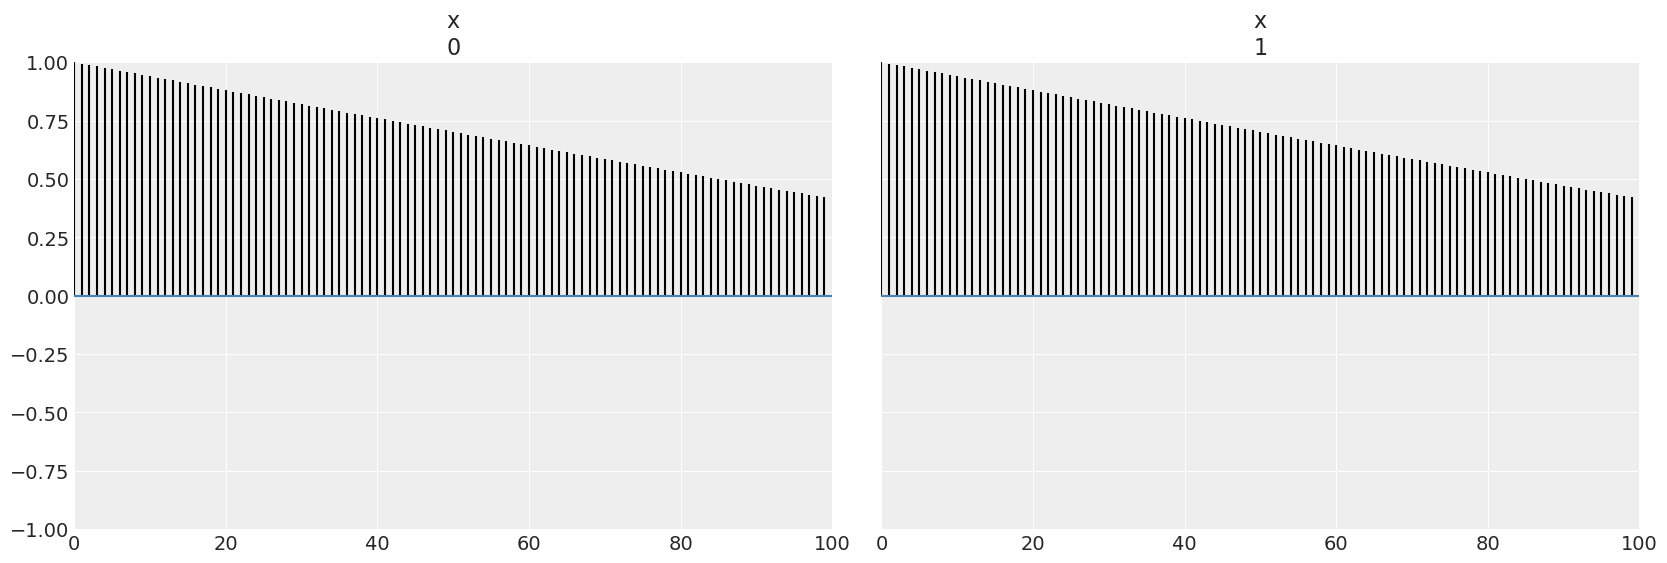

In [6]:
bad_chains = np.linspace(0, 1, 1000).reshape(2, -1)
az.plot_autocorr(bad_chains);

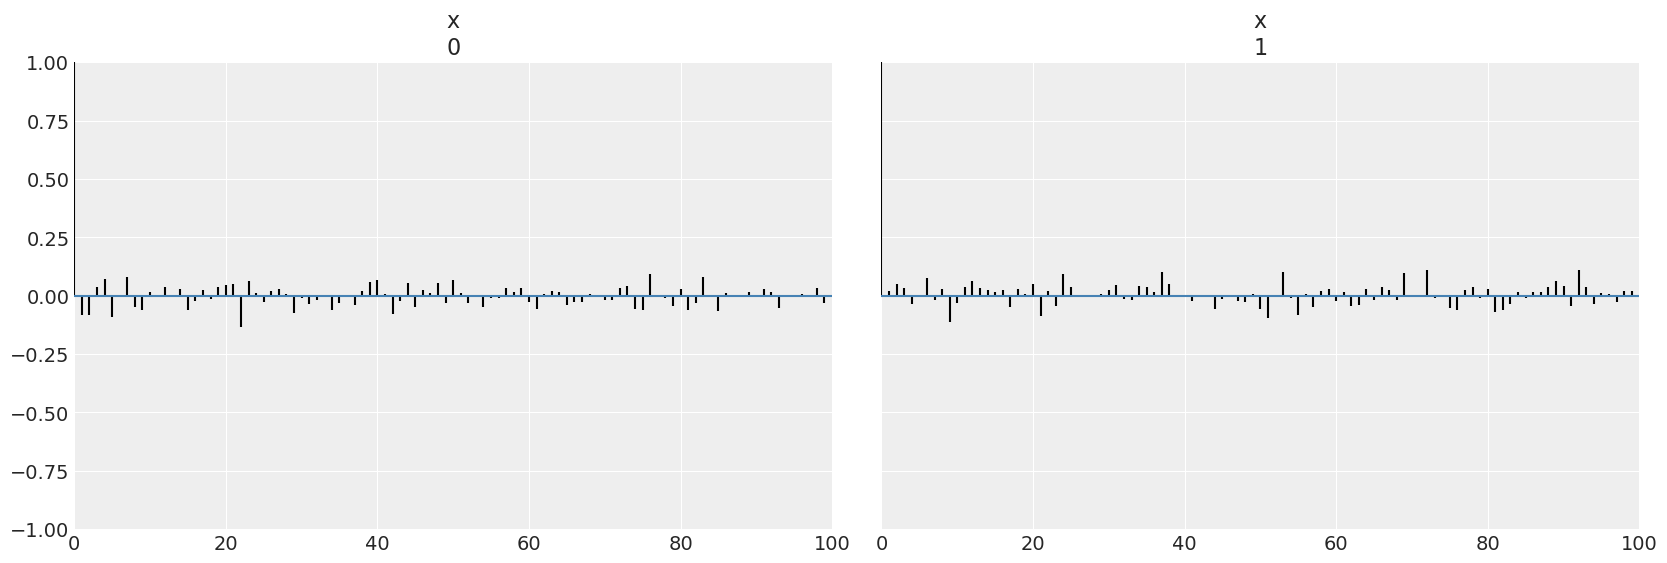

In [7]:
good_chains = stats.uniform.rvs(0, 1,size=(2,500))
az.plot_autocorr(good_chains);

## Como arreglarlo

* Más muestras (esto se vuelve cada vez menos práctico a medida que aumenta la autocorrelación)
* Reparametrizar el modelo
* ¡Siga los mensajes de advertencia y sugerencias de PyMC3!

## Tamaño de muestra efectivo (ess)

<br>

     az.ess (trace)

* Es la muestra lo suficientemente grande?

* Una muestra con autocorrelación tiene menos información que una muestra del mismo tamaño sin autocorrelación.

* Podemos estimar el **tamaño de muestra efectivo**, es decir, el tamaño de una muestra dada con la cantidad equivalente de información pero sin autocorrelación

!!!! XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
* Recomendamos exigir que el ESS (rank-normalized) sea superior a 400 
!!!! XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [8]:
az.ess(bad_chains), az.ess(good_chains)

(2.284600376742084, 1032.4518803020005)

In [9]:
az.summary(good_chains)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.503,0.292,0.056,0.99,0.009,0.006,1032.0,1032.0,1032.0,986.0,1.0


## $\hat R$  (R sombrerito)

* Lograron las cadenas mezclarse adecuadamente?

* Compara la varianza *entre* cadenas con la varianza *dentro* de cada cadena.

* Idealmente $\hat R =$1, en la práctica $\hat R \lessapprox 1.01$ son considerados seguros.

* Puede ser interpretado como la sobre-estimación de la varianza debido al muestreo finito de MCMC. 
    * Si continuas muestreando infinitamente, la varianza de las muestras se reduciría en un factor de $\hat R$.

Usando ArviZ podemos calcularlo usando `az.summary(⋅)` o usando `az.rhat(⋅)`

# error mcse

<br>

* Una de las cantidades devueltas por `summary` es mc_error.

* Esta es una estimación del error introducido por el método de muestreo.

* La estimación tiene en cuenta que las muestras no son realmente independientes entre sí.

* Este error debe estar por debajo de la precisión deseada en nuestros resultados

## Rank plot

<br>

     az.plot_rank ()


* Las gráficas de rango son histogramas de muestras *rankeadas* provenientes de la distribución *a posteriori*. El ranking se hace para todas las cadenas juntas, pero se grafica para cada cadena por separado.

* Los rangos tendrán una distribución uniforme si las cadenas son similares entre si.

* Además, si los rank plots lucen similares entre si entonces tenemos buen mezclado.

* Esta es una prueba visual recientemente propuesta, los autores argumentan que es superior al trace plot.



[Aki Vehtari y otros](https://arxiv.org/abs/1903.08008)

In [1]:
original_data = np.random.beta(2, 2, 1000)
ranked_data = stats.rankdata(original_data)

_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].plot(original_data, ranked_data, 'b.')
ax[0].set_xlabel('valores de los datos')
ax[0].set_ylabel('rango')
ax[0].set_xlim([0, 1])
ax[1].hist(ranked_data, bins=10, rwidth=0.9, orientation='horizontal')
ax[1].set_xlabel('frecuency');

NameError: name 'np' is not defined

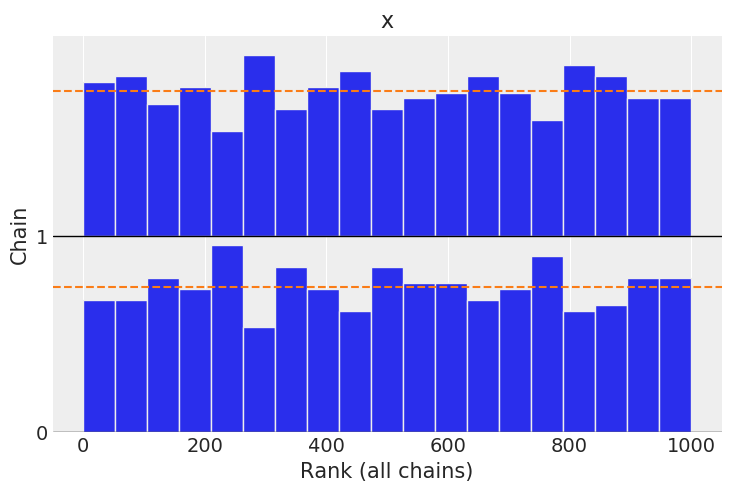

In [11]:
az.plot_rank(good_chains);

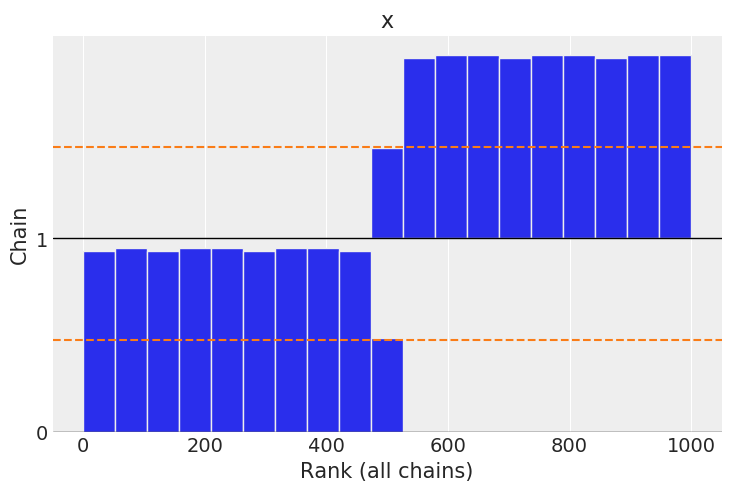

In [12]:
az.plot_rank(bad_chains);

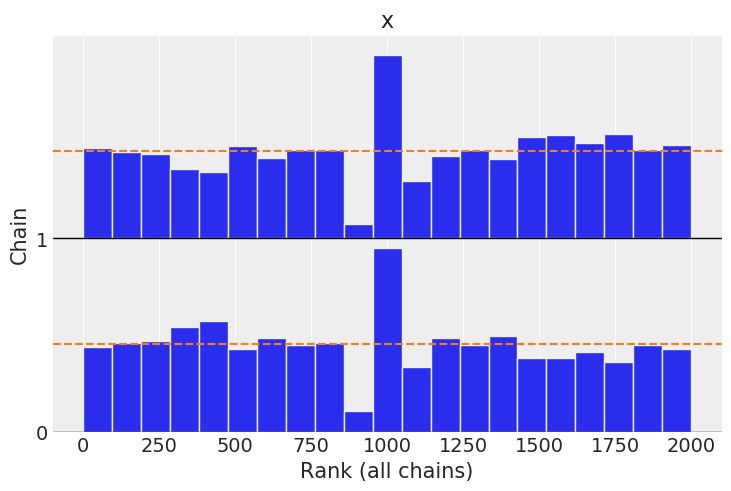

In [13]:
dada = np.random.normal(0, 1, (2, 1000))
dada[:,0:100] = 0
az.plot_rank(dada);

## Ejercicio

Ejecuta los siguientes modelos y diagnostica el muestreo

In [14]:
with pm.Model() as good_model:
    μ = pm.Normal('μ', 0, 1000, shape=2)
    y = pm.Poisson('y', np.exp(μ), observed=[1, 10])
    good_samples = pm.sample(1000)
    
with pm.Model() as bad_model:
    μ = pm.Normal('μ', 0, 1000, shape=2)
    y = pm.Poisson('y', np.exp(μ[0] + μ[1]), observed=[1])
    bad_samples = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2579.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [01:21<00:00, 36.80draws/s]
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6515955176701023, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6597373245097112, but should be close to 0.8. Try to increase the number of tuning steps.
The chain re

## Diagnóstico de algoritmos basados en gradiente

<br>


* Debido a su funcionamiento interno, algoritmos como NUTS  ofrecen algunas pruebas específicas que no están disponibles para otros métodos


* Generalmente estas pruebas son muy sensibles

In [15]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    trace_cm = pm.sample(2000, random_seed=7)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    bof = pm.Normal('bof', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + bof * a)
    trace_ncm = pm.sample(2000, random_seed=7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:08<00:00, 591.82draws/s] 
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.537087638612188, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bof, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1260.44draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Energía de transición vs energía marginal

<br>

* Podemos pensar en un Hamiltoniano MonteCarlo como un proceso de dos pasos
     * Un muestreo determinista (siguiendo el hamiltoniano)
     * Una caminata aleatorio en el espacio del momentum


* Si la distribución de la energía de transición es similar a la distribución de la energía marginal, entonces NUTS es capaz de generar muestras de la distribución marginal de la energía que sean *casi* independientes entre transiciones. 



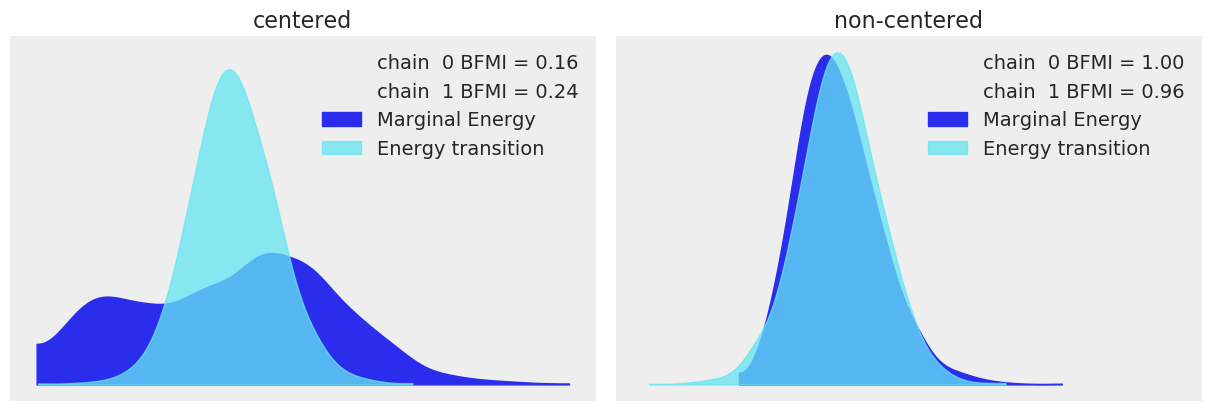

In [16]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_energy(tr, ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

## Divergencias

<br>

* Una ventaja de NUTS es que *falla con el estilo*

* Cuando las trayectorias exactas se encuentran en regiones de alta curvatura, las trayectorias numéricas pueden divergir

* Las trayectorias numéricas divergentes son identificadores extremadamente sensibles de *vecindarios patológicos* y, por lo tanto, proporcionan un diagnóstico potente e inmediato.


[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)

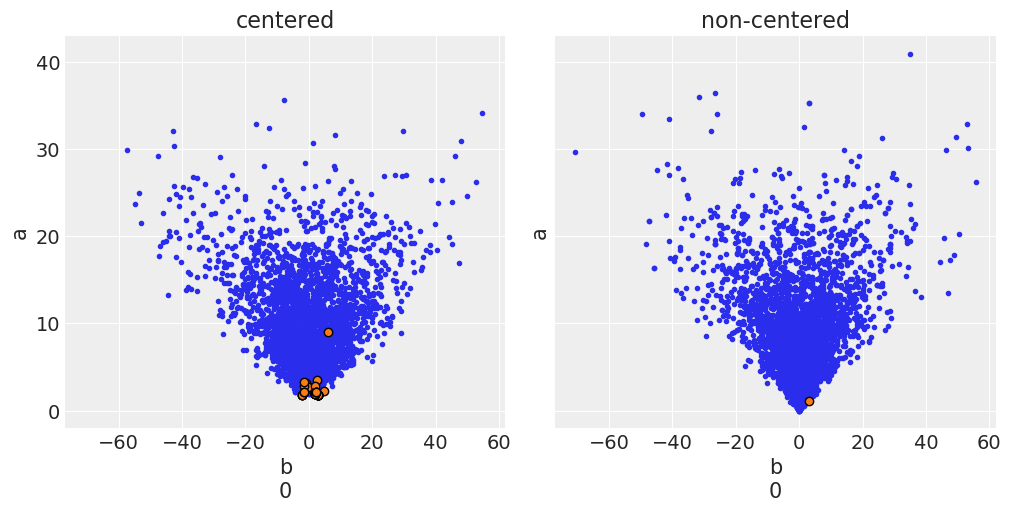

In [17]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, contour=False, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

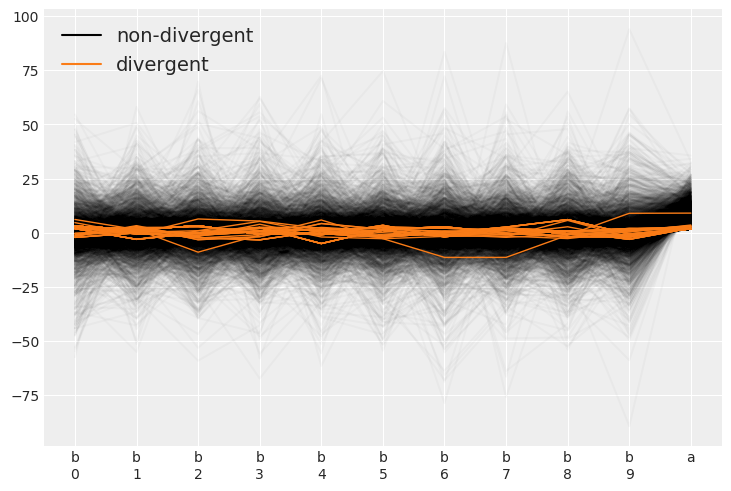

In [18]:
az.plot_parallel(trace_cm);

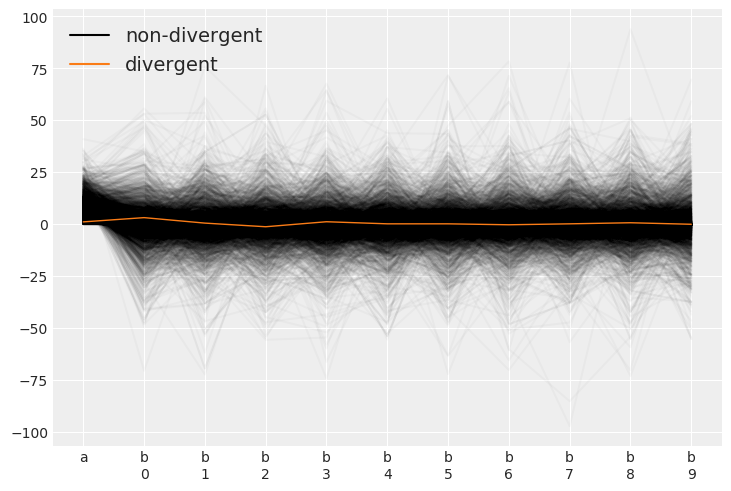

In [19]:
az.plot_parallel(trace_ncm, var_names=['~bof']);

## Cómo solucionar divergencias


* Cuando las patologías son lo suficientemente leves, las divergencias pueden eliminarse aumentando la tasa de aceptación deseada (`target_accept`), internamente NUTS realizará un paso más pequeño.

* Cuando las patologías son demasiado graves, se necesitan otras medidas, que incluyen:
     * Usar prior más fuertes
     * Reparametrización del modelo.